In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit, logit
from sklearn.preprocessing import FunctionTransformer

from skpro.metrics import CRPS, LogLoss
from skpro.regression.compose import TransformedTargetRegressor
from skpro.regression.xgboostlss import XGBoostLSS

# from sklearn.preprocessing import MinMaxScaler


size = 1000

X = np.random.normal(1, 1, size)
y = 2 * X + np.random.normal(0, 0.5, size)

Xy = pd.DataFrame({"target": y, "feature": X}, index=range(size))

In [2]:
crpss = []
lls = []

In [3]:
params = {"n_trials": 0, "dist": "Normal"}

In [4]:
xgb = XGBoostLSS(**params)
xgb.fit(X=Xy[["feature"]], y=Xy["target"])
p = xgb.predict(Xy[["feature"]])
pp = xgb.predict_proba(Xy[["feature"]])
crpss.append(CRPS()(y_true=Xy["target"], y_pred=pp))
print(crpss[-1])

/Users/j.dunn/miniforge3/envs/skpro-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.22683387930035218


0.3640238931971838

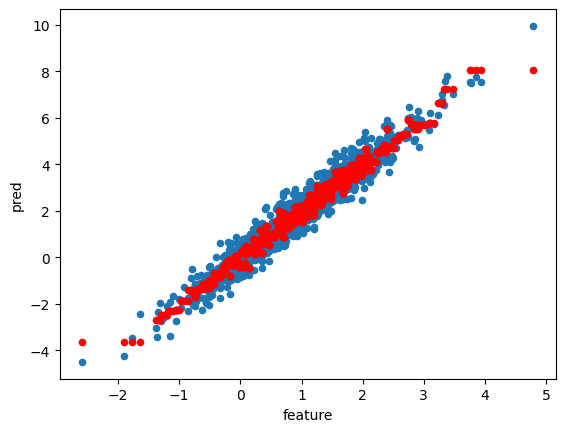

In [5]:
ax = Xy.plot.scatter(x="feature", y="target")
Xy.assign(pred=p).plot.scatter(x="feature", y="pred", color="red", ax=ax)
lls.append(LogLoss()(y_true=Xy["target"], y_pred=pp))
lls[-1]

In [ ]:
xgb = XGBoostLSS(**params)
transf = FunctionTransformer(func=expit, inverse_func=logit)
# uncomment to use MinMaxScaler for simple `scale_` based jacobian
# transf = MinMaxScaler()

pipe = TransformedTargetRegressor(
    regressor=xgb, transformer=transf, numerical_diff=True
)

pipe.fit(X=Xy[["feature"]], y=Xy["target"])
pp = pipe.predict_proba(Xy[["feature"]])

p = pipe.predict(Xy[["feature"]])
crpss.append(CRPS()(y_true=Xy["target"], y_pred=pp))

In [ ]:
jac = pp._jacobian(Xy[["feature"]])
jac[:5]

array([14.30620938,  4.46018735,  7.46651355,  4.27788092, 12.67968354])

0.41411837570177035

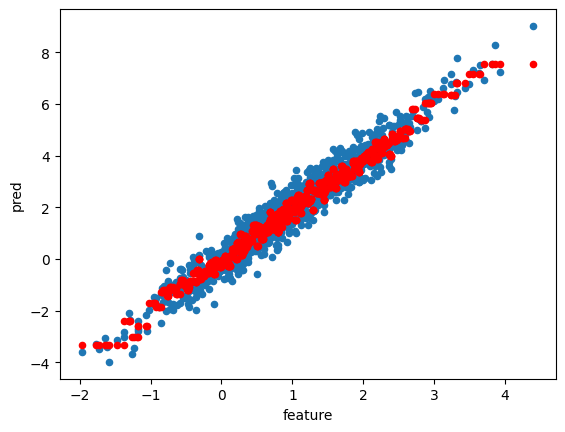

In [ ]:
ax = Xy.plot.scatter(x="feature", y="target")
Xy.assign(pred=p).plot.scatter(x="feature", y="pred", color="red", ax=ax)
lls.append(LogLoss()(y_true=Xy["target"], y_pred=pp))
lls[-1]

In [ ]:
xgb = XGBoostLSS(**params)
y_ = transf.fit_transform(Xy[["target"]])

xgb.fit(X=Xy[["feature"]], y=y_)
pp = xgb.predict_proba(Xy[["feature"]])
p = xgb.predict(Xy[["feature"]])
p_ = transf.inverse_transform(p)

crpss.append(CRPS()(y_true=y_, y_pred=pp))
print(crpss[-1])
ll = LogLoss()(y_true=y_, y_pred=pp)
lls.append(ll)
lls[-1]

0.02687018959393225


-2.2543461555925104

In [ ]:
from skpro.distributions.trafo._transformed import ordered_gradient

jac = np.abs(ordered_gradient(y_.values.reshape(-1), y.reshape(-1)))
jac

array([9.06148276e-03, 1.60151491e-01, 3.81884671e-02, 1.48966284e-01,
       5.55233937e-03, 2.49140427e-01, 3.67787573e-02, 1.00642785e-02,
       1.92922813e-02, 6.94454467e-02, 2.15578770e-02, 1.23703511e-01,
       4.24781025e-02, 1.45003746e-01, 2.15511444e-01, 2.25812373e-01,
       2.40040433e-02, 9.02159491e-03, 4.26607050e-04, 1.48540774e-01,
       1.11688856e-01, 8.96732337e-02, 1.02461320e-01, 5.17748908e-02,
       3.54344643e-02, 1.18483434e-01, 2.42463049e-01, 2.39545913e-01,
       1.87362422e-03, 1.03245002e-01, 1.85192967e-01, 9.05186869e-03,
       3.43714503e-02, 7.54891414e-02, 3.49430211e-02, 1.28216192e-01,
       7.85730192e-02, 1.66074697e-02, 1.72030849e-01, 2.43779347e-02,
       2.08308964e-01, 2.39286772e-01, 2.43162101e-01, 1.64718695e-01,
       5.38297276e-02, 2.39818716e-01, 2.06272191e-01, 1.39187473e-01,
       7.41994940e-02, 1.60602168e-02, 6.95090084e-02, 9.94916385e-02,
       3.42987837e-02, 3.43589519e-02, 2.14616610e-01, 1.49013658e-01,
      

In [ ]:
crpss.append(
    (CRPS().evaluate_by_index(y_true=y_, y_pred=pp) / jac.reshape(-1, 1)).mean()[0]
)

print(crpss[-1])
lls.append((ll - np.log(jac)).mean())
lls[-1]

0.26193932002803044


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


0.41373794916832524

<Axes: xlabel='feature', ylabel='pred_'>

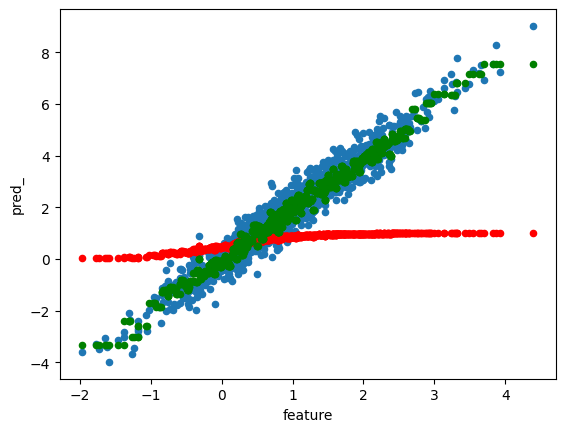

In [ ]:
ax = Xy.plot.scatter(x="feature", y="target")
Xy.assign(pred=p).plot.scatter(x="feature", y="pred", color="red", ax=ax)
Xy.assign(pred_=p_).plot.scatter(x="feature", y="pred_", color="green", ax=ax)

In [ ]:
res = pd.DataFrame(
    {"CRPS": crpss, "LogLoss": lls},
    index=[
        "no-scaling",
        "TTR",
        "Tranform (score in transformed space)",
        "Transform + Jacobian",
    ],
)

print("Comparison of different transformation methods:")
res

Comparison of different transformation methods:


,CRPS,LogLoss
no-scaling,0.231490,0.386058
TTR,0.171741,0.414118
Tranform (score in transformed space),0.026870,-2.254346
Transform + Jacobian,0.261939,0.413738
